In [10]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [11]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [12]:
from pytket.circuit import CircBox
from pytket.circuit import QControlBox

In [13]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

In [14]:
from pytket.circuit import Op
from pytket.circuit import OpType
prep_circ = Circuit(4)
render_circuit_jupyter(prep_circ)

In [15]:
prep_circ.Rz(-0.05,0)
prep_circ.Rz(0.05,1)
prep_circ.Rz(-0.228,0)
prep_circ.Rz(-0.05,1)
prep_circ.Rz(0.05,2)
prep_circ.Rx(0.974,0)
prep_circ.Rz(-0.228,1)
prep_circ.Rz(-0.05,2)
prep_circ.Rz(0.05,3)
prep_circ.Rx(0.974,1)
prep_circ.Rz(-0.228,2)
prep_circ.Rz(-0.228,3)
prep_circ.Rz(-0.05,0)
prep_circ.Rz(0.05,1)
prep_circ.Rx(0.974,2)
prep_circ.Rx(0.974,3)
prep_circ.Rz(-0.05,1)
prep_circ.Rz(0.05,2)
prep_circ.Rz(-0.05,2)
prep_circ.Rz(0.05,3)
render_circuit_jupyter(prep_circ)

In [21]:
preparation_circuit = Circuit(4)# prepare the |1> eigenstate of U1


unitary_circuit = prep_circ  # Base unitary for controlled U ops
qpe_circ_trivial = build_phase_estimation_circuit(
    4, state_prep_circuit=preparation_circuit, unitary_circuit=unitary_circuit
)
render_circuit_jupyter(qpe_circ_trivial)

In [22]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)
print(result.get_counts())

Counter({(1, 0, 0, 0): 447, (0, 0, 0, 0): 436, (0, 1, 1, 1): 23, (1, 1, 1, 1): 23, (1, 0, 0, 1): 22, (0, 0, 0, 1): 17, (1, 0, 1, 0): 8, (1, 1, 0, 0): 5, (0, 0, 1, 0): 3, (0, 1, 0, 1): 3, (0, 1, 1, 0): 3, (1, 1, 0, 1): 3, (1, 1, 1, 0): 3, (0, 1, 0, 0): 2, (0, 0, 1, 1): 1, (1, 0, 1, 1): 1})


In [23]:
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

In [24]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

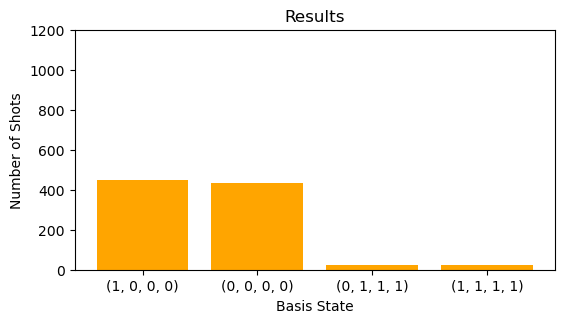

In [25]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))